# Option Pricing: Binomial Tree and Monte Carlo Comparison

This notebook implements:
- One-step and two-step binomial trees (CRR and GBM)
- Monte Carlo simulation with Geometric Brownian Motion
- Black-Scholes analytical pricing for comparison

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import math

## Black-Scholes Functions

In [2]:
def black_scholes_d1(S, K, r, d, sigma, T):
    """Calculate d1 parameter for Black-Scholes"""
    return (np.log(S/K) + (r - d + sigma**2 / 2) * T) / (sigma * np.sqrt(T))

def black_scholes_d2(S, K, r, d, sigma, T):
    """Calculate d2 parameter for Black-Scholes"""
    d1 = black_scholes_d1(S, K, r, d, sigma, T)
    return d1 - sigma * np.sqrt(T)

def black_scholes_call(S, K, r, d, sigma, T):
    """Black-Scholes European call option price"""
    d1 = black_scholes_d1(S, K, r, d, sigma, T)
    d2 = black_scholes_d2(S, K, r, d, sigma, T)
    return S * np.exp(-d * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def black_scholes_put(S, K, r, d, sigma, T):
    """Black-Scholes European put option price"""
    d1 = black_scholes_d1(S, K, r, d, sigma, T)
    d2 = black_scholes_d2(S, K, r, d, sigma, T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-d * T) * norm.cdf(-d1)

## One-Step Binomial Tree

In [3]:
def one_step_binomial_crr(S0, K, r, d, sigma, T, option_type='call'):
    """
    One-step binomial tree using CRR parameters
    
    Parameters:
    -----------
    S0 : float
        Initial stock price
    K : float
        Strike price
    r : float
        Risk-free rate
    d : float
        Dividend yield
    sigma : float
        Volatility
    T : float
        Time to maturity
    option_type : str
        'call' or 'put'
    
    Returns:
    --------
    option_price : float
        Option price at t=0
    stock_tree : ndarray
        Stock prices at each node
    option_tree : ndarray
        Option values at each node
    """
    dt = T
    
    # CRR parameters
    u = np.exp(sigma * np.sqrt(dt))
    d_factor = 1 / u
    
    # Risk-neutral probability
    p = (np.exp((r - d) * dt) - d_factor) / (u - d_factor)
    
    # Stock prices at maturity
    S_up = S0 * u
    S_down = S0 * d_factor
    
    # Option payoffs at maturity
    if option_type == 'call':
        payoff_up = max(S_up - K, 0)
        payoff_down = max(S_down - K, 0)
    else:
        payoff_up = max(K - S_up, 0)
        payoff_down = max(K - S_down, 0)
    
    # Discount back to present
    option_price = np.exp(-r * dt) * (p * payoff_up + (1 - p) * payoff_down)
    
    # Store trees - corrected to use consistent structure
    stock_tree = np.array([[S0, np.nan], [S_up, S_down]])
    option_tree = np.array([[option_price, np.nan], [payoff_up, payoff_down]])
    
    return option_price, stock_tree, option_tree, p, u, d_factor

def one_step_binomial_gbm(S0, K, r, d, sigma, T, option_type='call'):
    """
    One-step binomial tree using GBM parameters
    """
    dt = T
    
    # GBM parameters
    det_comp = (r - d - 0.5 * sigma**2) * dt
    stoc_comp = sigma * np.sqrt(dt)
    u = np.exp(det_comp + stoc_comp)
    d_factor = np.exp(det_comp - stoc_comp)
    
    # Risk-neutral probability
    p = (np.exp((r - d) * dt) - d_factor) / (u - d_factor)
    
    # Stock prices at maturity
    S_up = S0 * u
    S_down = S0 * d_factor
    
    # Option payoffs at maturity
    if option_type == 'call':
        payoff_up = max(S_up - K, 0)
        payoff_down = max(S_down - K, 0)
    else:
        payoff_up = max(K - S_up, 0)
        payoff_down = max(K - S_down, 0)
    
    # Discount back to present
    option_price = np.exp(-r * dt) * (p * payoff_up + (1 - p) * payoff_down)
    
    # Store trees - corrected to use consistent structure
    stock_tree = np.array([[S0, np.nan], [S_up, S_down]])
    option_tree = np.array([[option_price, np.nan], [payoff_up, payoff_down]])
    
    return option_price, stock_tree, option_tree, p, u, d_factor

## Two-Step Binomial Tree

In [4]:
def two_step_binomial_crr(S0, K, r, d, sigma, T, option_type='call', american=False):
    """
    Two-step binomial tree using CRR parameters
    
    Parameters:
    -----------
    S0 : float
        Initial stock price
    K : float
        Strike price
    r : float
        Risk-free rate
    d : float
        Dividend yield
    sigma : float
        Volatility
    T : float
        Time to maturity
    option_type : str
        'call' or 'put'
    american : bool
        True for American option, False for European
    
    Returns:
    --------
    option_price : float
        Option price at t=0
    stock_tree : ndarray
        Stock prices at each node
    option_tree : ndarray
        Option values at each node
    """
    N = 2
    dt = T / N
    
    # CRR parameters
    u = np.exp(sigma * np.sqrt(dt))
    d_factor = 1 / u
    
    # Risk-neutral probability
    p = (np.exp((r - d) * dt) - d_factor) / (u - d_factor)
    discount = np.exp(-r * dt)
    
    # Initialize stock price tree
    stock_tree = np.zeros((N + 1, N + 1))
    stock_tree[0, 0] = S0
    
    # Build stock price tree
    for i in range(N):
        for j in range(i + 1):
            stock_tree[j, i + 1] = stock_tree[j, i] * u
        stock_tree[i + 1, i + 1] = stock_tree[i, i] * d_factor
    
    # Initialize option value tree
    option_tree = np.zeros((N + 1, N + 1))
    
    # Calculate payoffs at maturity
    for j in range(N + 1):
        if option_type == 'call':
            option_tree[j, N] = max(stock_tree[j, N] - K, 0)
        else:
            option_tree[j, N] = max(K - stock_tree[j, N], 0)
    
    # Backward induction
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            option_tree[j, i] = discount * (p * option_tree[j, i + 1] + 
                                           (1 - p) * option_tree[j + 1, i + 1])
            
            # Early exercise for American options
            if american:
                if option_type == 'call':
                    exercise_value = max(stock_tree[j, i] - K, 0)
                else:
                    exercise_value = max(K - stock_tree[j, i], 0)
                option_tree[j, i] = max(option_tree[j, i], exercise_value)
    
    return option_tree[0, 0], stock_tree, option_tree, p, u, d_factor

## N-Step Binomial Tree

In [5]:
def n_step_binomial_crr(S0, K, r, d, sigma, T, N, option_type='call', american=False):
    """
    N-step binomial tree using CRR parameters
    """
    dt = T / N
    
    # CRR parameters
    u = np.exp(sigma * np.sqrt(dt))
    d_factor = 1 / u
    
    # Risk-neutral probability
    p = (np.exp((r - d) * dt) - d_factor) / (u - d_factor)
    discount = np.exp(-r * dt)
    
    # Initialize stock price tree
    stock_tree = np.zeros((N + 1, N + 1))
    stock_tree[0, 0] = S0
    
    # Build stock price tree - FIXED: Correct indexing for down moves
    for i in range(N):
        # Up moves
        for j in range(i + 1):
            stock_tree[j, i + 1] = stock_tree[j, i] * u
        # Down move from the last node at time i
        stock_tree[i + 1, i + 1] = stock_tree[i, i] * d_factor
    
    # Initialize option value tree
    option_tree = np.zeros((N + 1, N + 1))
    
    # Calculate payoffs at maturity
    for j in range(N + 1):
        if option_type == 'call':
            option_tree[j, N] = max(stock_tree[j, N] - K, 0)
        else:
            option_tree[j, N] = max(K - stock_tree[j, N], 0)
    
    # Backward induction
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            option_tree[j, i] = discount * (p * option_tree[j, i + 1] + 
                                           (1 - p) * option_tree[j + 1, i + 1])
            
            # Early exercise for American options
            if american:
                if option_type == 'call':
                    exercise_value = max(stock_tree[j, i] - K, 0)
                else:
                    exercise_value = max(K - stock_tree[j, i], 0)
                option_tree[j, i] = max(option_tree[j, i], exercise_value)
    
    return option_tree[0, 0], stock_tree, option_tree

## Monte Carlo Simulation with Geometric Brownian Motion

In [6]:
def monte_carlo_gbm(S0, K, r, d, sigma, T, num_simulations, num_steps, option_type='call', seed=None):
    """
    Monte Carlo simulation using Geometric Brownian Motion
    
    Parameters:
    -----------
    S0 : float
        Initial stock price
    K : float
        Strike price
    r : float
        Risk-free rate
    d : float
        Dividend yield
    sigma : float
        Volatility
    T : float
        Time to maturity
    num_simulations : int
        Number of simulation paths
    num_steps : int
        Number of time steps
    option_type : str
        'call' or 'put'
    seed : int
        Random seed for reproducibility
    
    Returns:
    --------
    option_price : float
        Estimated option price
    std_error : float
        Standard error of the estimate
    paths : ndarray
        Simulated stock price paths
    """
    if seed is not None:
        np.random.seed(seed)
    
    dt = T / num_steps
    
    # Initialize paths array
    paths = np.zeros((num_simulations, num_steps + 1))
    paths[:, 0] = S0
    
    # Generate random numbers
    Z = np.random.standard_normal((num_simulations, num_steps))
    
    # Simulate paths
    for t in range(1, num_steps + 1):
        paths[:, t] = paths[:, t - 1] * np.exp((r - d - 0.5 * sigma**2) * dt + 
                                                 sigma * np.sqrt(dt) * Z[:, t - 1])
    
    # Calculate payoffs
    if option_type == 'call':
        payoffs = np.maximum(paths[:, -1] - K, 0)
    else:
        payoffs = np.maximum(K - paths[:, -1], 0)
    
    # Discount to present value
    option_price = np.exp(-r * T) * np.mean(payoffs)
    std_error = np.exp(-r * T) * np.std(payoffs) / np.sqrt(num_simulations)
    
    return option_price, std_error, paths

## Comparisons

In [7]:
# Parameters
S0 = 100.0
K = 100.0
r = 0.05
d = 0.02
sigma = 0.2
T = 1.0
option_type = 'call'

print("="*60)
print("OPTION PRICING COMPARISON")
print("="*60)
print(f"Parameters:")
print(f"S0 = {S0}, K = {K}, r = {r}, d = {d}, sigma = {sigma}, T = {T}")
print(f"Option type: {option_type}")
print("="*60)

# Black-Scholes
bs_price = black_scholes_call(S0, K, r, d, sigma, T)
print(f"\nBlack-Scholes Price: {bs_price:.6f}")

# One-step binomial CRR
one_step_crr_price, _, _, p1, u1, d1 = one_step_binomial_crr(S0, K, r, d, sigma, T, option_type)
print(f"\nOne-Step Binomial (CRR): {one_step_crr_price:.6f}")
print(f"  u = {u1:.6f}, d = {d1:.6f}, p = {p1:.6f}")

# One-step binomial GBM
one_step_gbm_price, _, _, p2, u2, d2 = one_step_binomial_gbm(S0, K, r, d, sigma, T, option_type)
print(f"\nOne-Step Binomial (GBM): {one_step_gbm_price:.6f}")
print(f"  u = {u2:.6f}, d = {d2:.6f}, p = {p2:.6f}")

# Two-step binomial CRR
two_step_price, stock_tree, option_tree, p3, u3, d3 = two_step_binomial_crr(S0, K, r, d, sigma, T, option_type)
print(f"\nTwo-Step Binomial (CRR): {two_step_price:.6f}")
print(f"  u = {u3:.6f}, d = {d3:.6f}, p = {p3:.6f}")

# N-step convergence
print("\nN-Step Binomial Convergence:")
for N in [5, 10, 20, 50, 100]:
    price, _, _ = n_step_binomial_crr(S0, K, r, d, sigma, T, N, option_type)
    error = abs(price - bs_price)
    print(f"  N = {N:3d}: Price = {price:.6f}, Error = {error:.6f}")

# Monte Carlo
print("\nMonte Carlo Simulation (GBM):")
for num_sim in [1000, 10000, 100000]:
    mc_price, mc_std_error, _ = monte_carlo_gbm(S0, K, r, d, sigma, T, num_sim, 100, option_type, seed=42)
    print(f"  {num_sim:6d} simulations: Price = {mc_price:.6f}, Std Error = {mc_std_error:.6f}")



OPTION PRICING COMPARISON
Parameters:
S0 = 100.0, K = 100.0, r = 0.05, d = 0.02, sigma = 0.2, T = 1.0
Option type: call

Black-Scholes Price: 9.227006

One-Step Binomial (CRR): 11.073541
  u = 1.221403, d = 0.818731, p = 0.525797

One-Step Binomial (GBM): 11.121502
  u = 1.233678, d = 0.826959, p = 0.500334

Two-Step Binomial (CRR): 8.342293
  u = 1.151910, d = 0.868123, p = 0.517959

N-Step Binomial Convergence:
  N =   5: Price = 9.602489, Error = 0.375483
  N =  10: Price = 9.035326, Error = 0.191680
  N =  20: Price = 9.130450, Error = 0.096556
  N =  50: Price = 9.188225, Error = 0.038781
  N = 100: Price = 9.207590, Error = 0.019416

Monte Carlo Simulation (GBM):
    1000 simulations: Price = 9.640430, Std Error = 0.470263
   10000 simulations: Price = 9.104506, Std Error = 0.140479
  100000 simulations: Price = 9.154498, Std Error = 0.043511


## Visualization

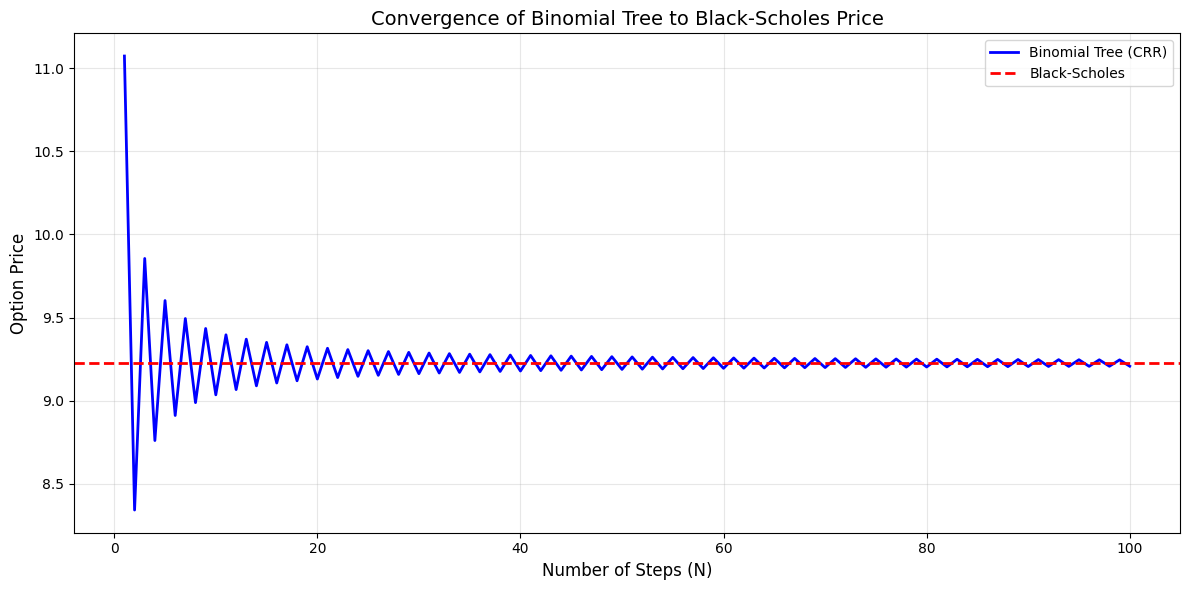

In [8]:
# Plot convergence of binomial tree
N_values = range(1, 101)
binomial_prices = []
for N in N_values:
    price, _, _ = n_step_binomial_crr(S0, K, r, d, sigma, T, N, option_type)
    binomial_prices.append(price)

plt.figure(figsize=(12, 6))
plt.plot(N_values, binomial_prices, 'b-', label='Binomial Tree (CRR)', linewidth=2)
plt.axhline(y=bs_price, color='r', linestyle='--', label='Black-Scholes', linewidth=2)
plt.xlabel('Number of Steps (N)', fontsize=12)
plt.ylabel('Option Price', fontsize=12)
plt.title('Convergence of Binomial Tree to Black-Scholes Price', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



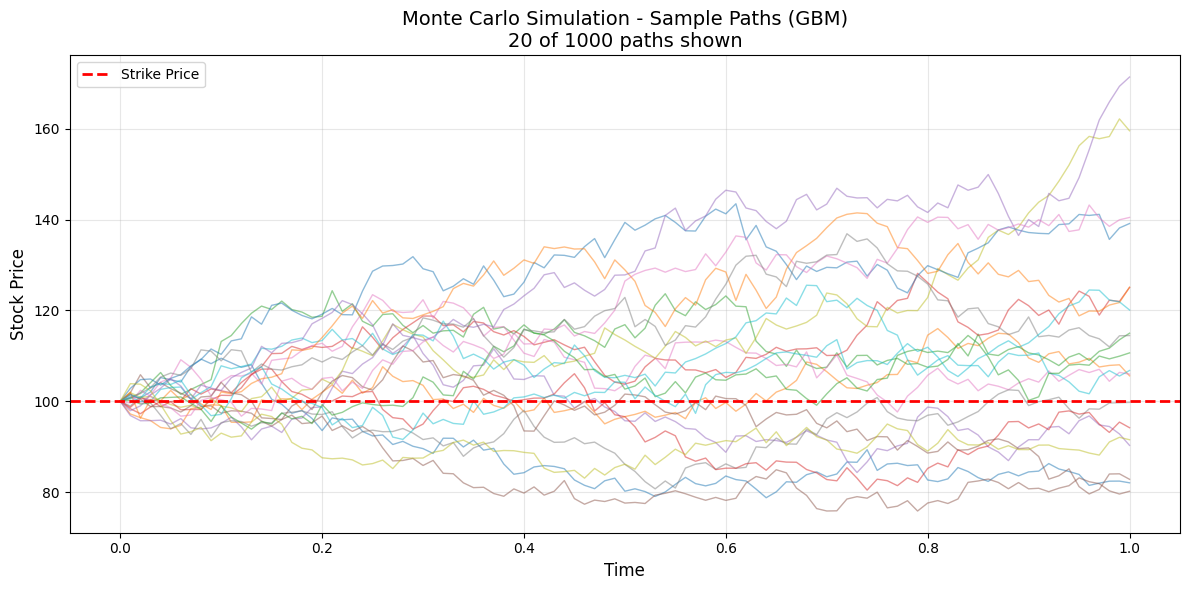

In [9]:
# Monte Carlo path visualization
num_paths_to_plot = 20
mc_price, mc_std_error, paths = monte_carlo_gbm(S0, K, r, d, sigma, T, 1000, 100, option_type, seed=42)

plt.figure(figsize=(12, 6))
time_grid = np.linspace(0, T, paths.shape[1])

for i in range(num_paths_to_plot):
    plt.plot(time_grid, paths[i, :], alpha=0.5, linewidth=1)

plt.axhline(y=K, color='r', linestyle='--', linewidth=2, label='Strike Price')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.title(f'Monte Carlo Simulation - Sample Paths (GBM)\n{num_paths_to_plot} of 1000 paths shown', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Two-Step Binomial Tree Visualization

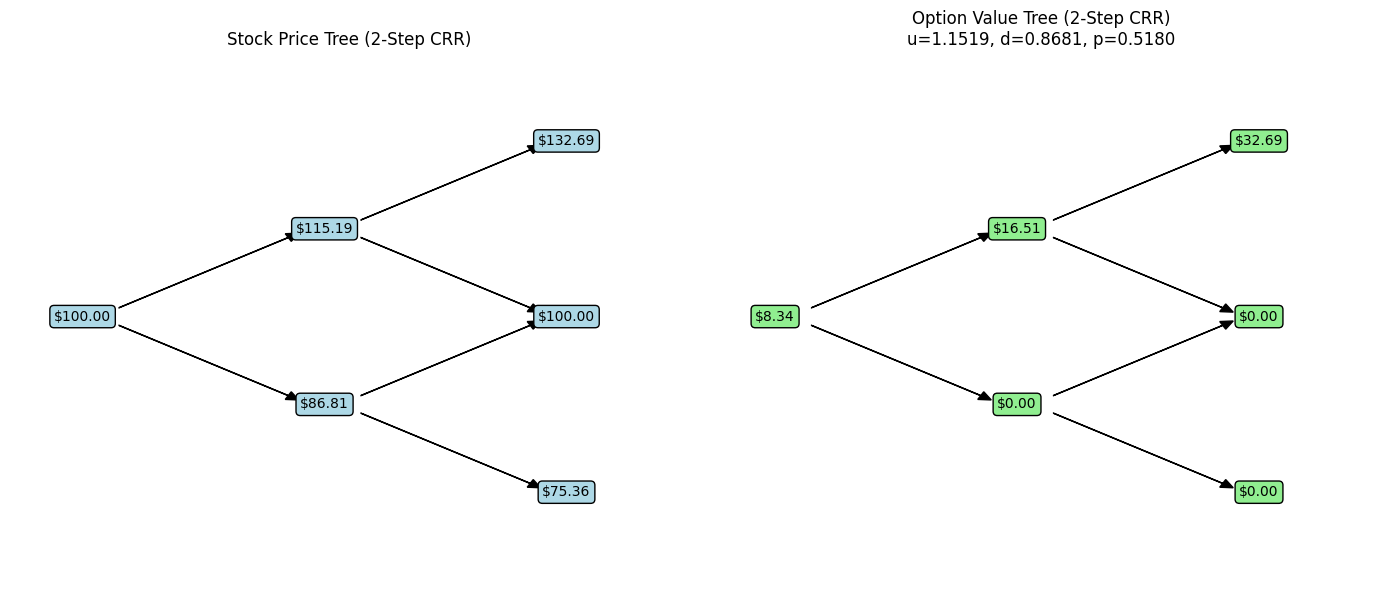

In [10]:
# Visualize two-step binomial tree
two_step_price, stock_tree_2step, option_tree_2step, p_2step, u_2step, d_2step = two_step_binomial_crr(
    S0, K, r, d, sigma, T, option_type
)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Stock price tree
ax1 = axes[0]
# Corrected coordinates for tree nodes
ax1.text(0, 0, f'${stock_tree_2step[0, 0]:.2f}', ha='center', va='center', 
         bbox=dict(boxstyle='round', facecolor='lightblue', edgecolor='black'), fontsize=10)

ax1.text(1, 0.5, f'${stock_tree_2step[0, 1]:.2f}', ha='center', va='center',
         bbox=dict(boxstyle='round', facecolor='lightblue', edgecolor='black'), fontsize=10)
ax1.text(1, -0.5, f'${stock_tree_2step[1, 1]:.2f}', ha='center', va='center',
         bbox=dict(boxstyle='round', facecolor='lightblue', edgecolor='black'), fontsize=10)

ax1.text(2, 1, f'${stock_tree_2step[0, 2]:.2f}', ha='center', va='center',
         bbox=dict(boxstyle='round', facecolor='lightblue', edgecolor='black'), fontsize=10)
ax1.text(2, 0, f'${stock_tree_2step[1, 2]:.2f}', ha='center', va='center',
         bbox=dict(boxstyle='round', facecolor='lightblue', edgecolor='black'), fontsize=10)
ax1.text(2, -1, f'${stock_tree_2step[2, 2]:.2f}', ha='center', va='center',
         bbox=dict(boxstyle='round', facecolor='lightblue', edgecolor='black'), fontsize=10)

# Draw arrows
ax1.arrow(0.15, 0.05, 0.7, 0.4, head_width=0.05, head_length=0.05, fc='black', ec='black')
ax1.arrow(0.15, -0.05, 0.7, -0.4, head_width=0.05, head_length=0.05, fc='black', ec='black')
ax1.arrow(1.15, 0.55, 0.7, 0.4, head_width=0.05, head_length=0.05, fc='black', ec='black')
ax1.arrow(1.15, 0.45, 0.7, -0.4, head_width=0.05, head_length=0.05, fc='black', ec='black')
ax1.arrow(1.15, -0.45, 0.7, 0.4, head_width=0.05, head_length=0.05, fc='black', ec='black')
ax1.arrow(1.15, -0.55, 0.7, -0.4, head_width=0.05, head_length=0.05, fc='black', ec='black')

ax1.set_xlim(-0.3, 2.5)
ax1.set_ylim(-1.5, 1.5)
ax1.set_title('Stock Price Tree (2-Step CRR)', fontsize=12)
ax1.axis('off')

# Option value tree
ax2 = axes[1]
ax2.text(0, 0, f'${option_tree_2step[0, 0]:.2f}', ha='center', va='center',
         bbox=dict(boxstyle='round', facecolor='lightgreen', edgecolor='black'), fontsize=10)

ax2.text(1, 0.5, f'${option_tree_2step[0, 1]:.2f}', ha='center', va='center',
         bbox=dict(boxstyle='round', facecolor='lightgreen', edgecolor='black'), fontsize=10)
ax2.text(1, -0.5, f'${option_tree_2step[1, 1]:.2f}', ha='center', va='center',
         bbox=dict(boxstyle='round', facecolor='lightgreen', edgecolor='black'), fontsize=10)

ax2.text(2, 1, f'${option_tree_2step[0, 2]:.2f}', ha='center', va='center',
         bbox=dict(boxstyle='round', facecolor='lightgreen', edgecolor='black'), fontsize=10)
ax2.text(2, 0, f'${option_tree_2step[1, 2]:.2f}', ha='center', va='center',
         bbox=dict(boxstyle='round', facecolor='lightgreen', edgecolor='black'), fontsize=10)
ax2.text(2, -1, f'${option_tree_2step[2, 2]:.2f}', ha='center', va='center',
         bbox=dict(boxstyle='round', facecolor='lightgreen', edgecolor='black'), fontsize=10)

# Draw arrows
ax2.arrow(0.15, 0.05, 0.7, 0.4, head_width=0.05, head_length=0.05, fc='black', ec='black')
ax2.arrow(0.15, -0.05, 0.7, -0.4, head_width=0.05, head_length=0.05, fc='black', ec='black')
ax2.arrow(1.15, 0.55, 0.7, 0.4, head_width=0.05, head_length=0.05, fc='black', ec='black')
ax2.arrow(1.15, 0.45, 0.7, -0.4, head_width=0.05, head_length=0.05, fc='black', ec='black')
ax2.arrow(1.15, -0.45, 0.7, 0.4, head_width=0.05, head_length=0.05, fc='black', ec='black')
ax2.arrow(1.15, -0.55, 0.7, -0.4, head_width=0.05, head_length=0.05, fc='black', ec='black')

ax2.set_xlim(-0.3, 2.5)
ax2.set_ylim(-1.5, 1.5)
ax2.set_title(f'Option Value Tree (2-Step CRR)\nu={u_2step:.4f}, d={d_2step:.4f}, p={p_2step:.4f}', fontsize=12)
ax2.axis('off')

plt.tight_layout()
plt.show()

## Comparison of European vs American Options

In [11]:
print("="*60)
print("EUROPEAN VS AMERICAN OPTION PRICING")
print("="*60)
print(f"Parameters: S0={S0}, K={K}, r={r}, d={d}, sigma={sigma}, T={T}")
print("="*60)

# European Call
euro_call_bs = black_scholes_call(S0, K, r, d, sigma, T)
euro_call_bin, _, _ = n_step_binomial_crr(S0, K, r, d, sigma, T, 100, 'call', american=False)

# American Call
amer_call_bin, _, _ = n_step_binomial_crr(S0, K, r, d, sigma, T, 100, 'call', american=True)

# European Put
euro_put_bs = black_scholes_put(S0, K, r, d, sigma, T)
euro_put_bin, _, _ = n_step_binomial_crr(S0, K, r, d, sigma, T, 100, 'put', american=False)

# American Put
amer_put_bin, _, _ = n_step_binomial_crr(S0, K, r, d, sigma, T, 100, 'put', american=True)

print("\nCALL OPTIONS:")
print(f"  European (BS):        {euro_call_bs:.6f}")
print(f"  European (Binomial):  {euro_call_bin:.6f}")
print(f"  American (Binomial):  {amer_call_bin:.6f}")
print(f"  Early Exercise Premium: {amer_call_bin - euro_call_bin:.6f}")

print("\nPUT OPTIONS:")
print(f"  European (BS):        {euro_put_bs:.6f}")
print(f"  European (Binomial):  {euro_put_bin:.6f}")
print(f"  American (Binomial):  {amer_put_bin:.6f}")
print(f"  Early Exercise Premium: {amer_put_bin - euro_put_bin:.6f}")

EUROPEAN VS AMERICAN OPTION PRICING
Parameters: S0=100.0, K=100.0, r=0.05, d=0.02, sigma=0.2, T=1.0

CALL OPTIONS:
  European (BS):        9.227006
  European (Binomial):  9.207590
  American (Binomial):  9.207590
  Early Exercise Premium: 0.000000

PUT OPTIONS:
  European (BS):        6.330081
  European (Binomial):  6.310665
  American (Binomial):  6.651030
  Early Exercise Premium: 0.340365


## Monte Carlo Convergence Analysis

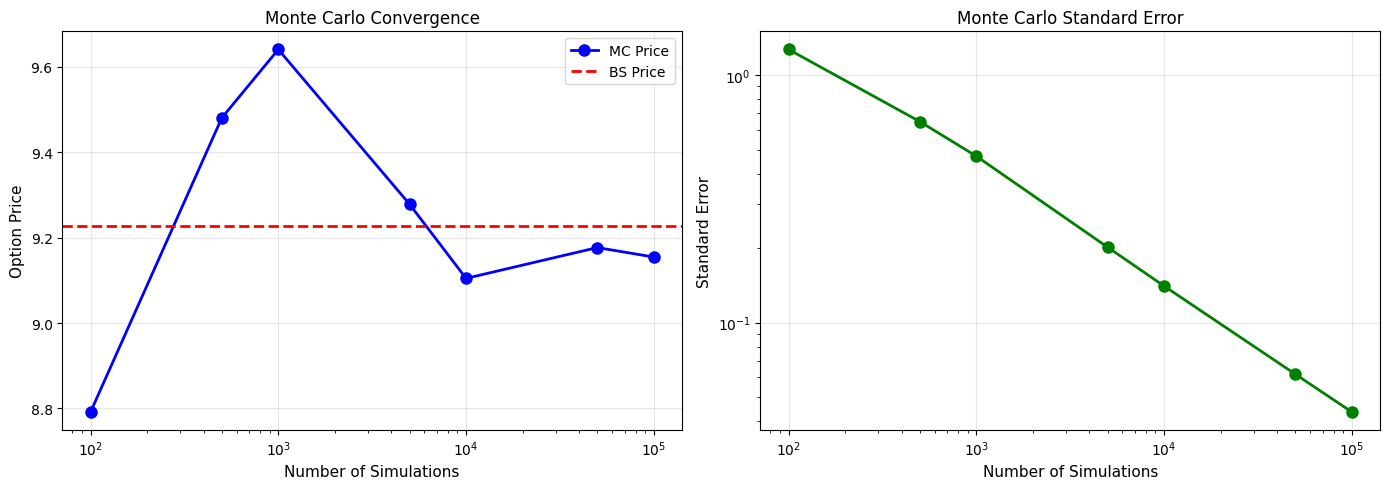

In [12]:
# Monte Carlo convergence
simulation_sizes = [100, 500, 1000, 5000, 10000, 50000, 100000]
mc_prices = []
mc_errors = []

for num_sim in simulation_sizes:
    price, std_err, _ = monte_carlo_gbm(S0, K, r, d, sigma, T, num_sim, 100, 'call', seed=42)
    mc_prices.append(price)
    mc_errors.append(std_err)

bs_ref = black_scholes_call(S0, K, r, d, sigma, T)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Convergence plot
axes[0].plot(simulation_sizes, mc_prices, 'bo-', linewidth=2, markersize=8, label='MC Price')
axes[0].axhline(y=bs_ref, color='r', linestyle='--', linewidth=2, label='BS Price')
axes[0].set_xscale('log')
axes[0].set_xlabel('Number of Simulations', fontsize=11)
axes[0].set_ylabel('Option Price', fontsize=11)
axes[0].set_title('Monte Carlo Convergence', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Standard error plot
axes[1].plot(simulation_sizes, mc_errors, 'go-', linewidth=2, markersize=8)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('Number of Simulations', fontsize=11)
axes[1].set_ylabel('Standard Error', fontsize=11)
axes[1].set_title('Monte Carlo Standard Error', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary Statistics Table

In [13]:
print("\n" + "="*80)
print("COMPREHENSIVE OPTION PRICING SUMMARY")
print("="*80)
print(f"\nUnderlying Parameters:")
print(f"  Current Stock Price (S0):     {S0:.2f}")
print(f"  Strike Price (K):             {K:.2f}")
print(f"  Risk-Free Rate (r):           {r:.4f} ({r*100:.2f}%)")
print(f"  Dividend Yield (d):           {d:.4f} ({d*100:.2f}%)")
print(f"  Volatility (sigma):           {sigma:.4f} ({sigma*100:.2f}%)")
print(f"  Time to Maturity (T):         {T:.4f} years")
print(f"  Moneyness (S0/K):             {S0/K:.4f}")

print(f"\n{'Method':<30} {'Call Price':<15} {'Put Price':<15}")
print("-"*60)
print(f"{'Black-Scholes':<30} {bs_price:.6f}       {black_scholes_put(S0, K, r, d, sigma, T):.6f}")

one_step_put_price = one_step_binomial_crr(S0, K, r, d, sigma, T, 'put')[0]
print(f"{'One-Step Binomial (CRR)':<30} {one_step_crr_price:.6f}       {one_step_put_price:.6f}")

two_step_put_price = two_step_binomial_crr(S0, K, r, d, sigma, T, 'put')[0]
print(f"{'Two-Step Binomial (CRR)':<30} {two_step_price:.6f}       {two_step_put_price:.6f}")

n100_call, _, _ = n_step_binomial_crr(S0, K, r, d, sigma, T, 100, 'call', False)
n100_put, _, _ = n_step_binomial_crr(S0, K, r, d, sigma, T, 100, 'put', False)
print(f"{'100-Step Binomial (CRR)':<30} {n100_call:.6f}       {n100_put:.6f}")

mc_call, mc_err_call, _ = monte_carlo_gbm(S0, K, r, d, sigma, T, 100000, 100, 'call', 42)
mc_put, mc_err_put, _ = monte_carlo_gbm(S0, K, r, d, sigma, T, 100000, 100, 'put', 42)
print(f"{'Monte Carlo (100k sims)':<30} {mc_call:.6f}       {mc_put:.6f}")


print("\n" + "="*80)
print("END OF ANALYSIS")
print("="*80)


COMPREHENSIVE OPTION PRICING SUMMARY

Underlying Parameters:
  Current Stock Price (S0):     100.00
  Strike Price (K):             100.00
  Risk-Free Rate (r):           0.0500 (5.00%)
  Dividend Yield (d):           0.0200 (2.00%)
  Volatility (sigma):           0.2000 (20.00%)
  Time to Maturity (T):         1.0000 years
  Moneyness (S0/K):             1.0000

Method                         Call Price      Put Price      
------------------------------------------------------------
Black-Scholes                  9.227006       6.330081
One-Step Binomial (CRR)        11.073541       8.176616
Two-Step Binomial (CRR)        8.342293       5.445368
100-Step Binomial (CRR)        9.207590       6.310665
Monte Carlo (100k sims)        9.154498       6.294353

END OF ANALYSIS
